Вначале установим библиотеку `catboost` и утилиту `shap` для визуализации важности признаков.  
Флаг `-q` позволяет отключить дебажный вывод. 

In [ ]:
!pip install -q catboost shap

In [ ]:
import numpy as np
import pandas as pd

import catboost
import catboost.datasets
import shap
import sklearn.model_selection

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

В `catboost` встроено несколько демонстрационных датасетов. Они сложнее и на порядок больше, чем датасеты из `sklearn`.

---

## Постановка задачи

Сегодня мы будем работать с [датасетом "Adult"](https://archive.ics.uci.edu/ml/datasets/adult). Это данные американского соцопроса 1994 года, задачей которого было исследовать, от чего зависит уровень дохода граждан. 

`Adult` -- традиционный датасет для иллюстрации бинарной классификации. Целевая переменная -- `income` -- имеет два значения: `<=50K` и `>50K`. Мы попробуем предсказать её, используя `catboost.CatBoostClassifier`. 

Мы будем обучать алгоритм только на исходном наборе признаков. *В качестве бонусного упражнения вам будет предложено придумать новые и добиться прироста качества с их помощью.*

#### Лирическое отступление

Градиентный бустинг традиционно показывает на задаче классификации лучшие результаты, чем на задаче регрессии. Но почему?

Это, в целом, разумно. При решении **задачи классификации** решающие деревья  предсказывают в листах *несмещённую оценку параметров условного распределения* -- $\mathrm{Bern}(p)$ или $\mathrm{Categorical}(p_1, \ldots, p_c)$ при наборе условий, задаваемых предикатами на пути от корня к этому листу.


А вот при решении **задачи регрессии** деревья предсказывают *первый момент соотв. условного ораспределения*, и в нём содержится *существенно меньше* информации о распределении (нельзя ничего сказать про его размах, асимметричность, пропорцию распределения массы между "центральной частью" и хвостами etc -- вся эта информация содержится в старших моментах)

## Описание данных

- `age` -- возраст в годах. Непрерывный признак. 

- `workclass` -- тип трудоустойства. Категориальный признак, множество допустимых значений: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 

- `fnlwgt` -- он же `final weight`. Непрерывный признак, который представляет собой эдакую одномерную проекцию социодемографических признаков опрошенного человека: авторами датасета гарантируется, что у похожих людей будут похожие значения этого принзака. Полное описание приведено в конце раздела.

- `education` -- уровень полученного образования. Категориальный признак, множество допустимых  значений: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 

- `education-num` -- количество лет обучения. Непрерывный признак. 

- `marital-status` -- семейное положение. Категориальный признак, множество допустимых значений: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 

- `occupation` -- род занятий. Категориальный признак, множество значений: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 

- `relationship` -- тоже семейное положение, но уже с акцентом на наличие / отсутствие детей. Категориальный признак, множество допустимых значений: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 

- `race` -- раса. Датасет американский, а американцы уделяют этому гораздо больше внимания, чем стоило бы. :) Категориальный признак, множество допустимых значений: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 

- `sex` -- пол. Категориальный признак, множество допустимых значений: Female, Male. 

- `capital-gain` -- суммарная прибыль от несвязанных с работой источников дохода (инвестиции, недвижимость etc) за последний год. Непрерывный призак.

- `capital-loss` -- суммарные убытки от несвязанных с работой источников дохода (инвестиции, недвижимость etc) за последний год. Непрерывный призак.

- `hours-per-week` -- количество рабочих часов в неделю. Непрерывный признак. 

- `native-country` -- страна происхождения. Категориальный признак, множество допустимых значений: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. Не очень понятно, зачем этот признак нужен, ведь там большая часть опрошенных из США, но что поделать.

Полное описание признака `fnlwght`:

```
The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.
Controls for Hispanic Origin by age and sex.
Controls by Race, age and sex.
We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.
```

#### Что можно сказать о данных?

14 признаков, из них всего 5 непрерывных. Очевидно, что нужно использовать алгоритм, который умеет эффективно работать с категориальными признаками. 

Стоит отметить, что `CatBoost` преобразует категориальные признаки в числовые, но использует для этого нетривиальный алгоритм, благодаря чему делает это эффективнее, чем у вас получится быстро сделать своими руками при помощи `sklearn`.

---

## Предобработка данных

In [ ]:
train_df, test_df = catboost.datasets.adult()

In [ ]:
print(
    '''
    Размеры выборок, (объекты, признаки).
    - Обучающая: {}
    - Тестовая: {}
    '''.format(
        train_df.shape,
        test_df.shape
    )
)


    Размеры выборок, (объекты, признаки).
    - Обучающая: (32561, 15)
    - Тестовая: (16281, 15)
    


Проверяем, что все столбцы на месте

In [ ]:
train_df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [ ]:
train_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [ ]:
train_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Посмотрим на данные чуть более пристально

In [ ]:
 cat_features = [
    'workclass', 
    'education', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
    'native-country'
]

In [ ]:
for feature in cat_features:
    print(f'Feature {feature}')
    display(train_df[feature].value_counts())
    print('-' * 40)

Feature workclass


Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

----------------------------------------
Feature education


HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

----------------------------------------
Feature marital-status


Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

----------------------------------------
Feature occupation


Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

----------------------------------------
Feature relationship


Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

----------------------------------------
Feature race


White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

----------------------------------------
Feature sex


Male      21790
Female    10771
Name: sex, dtype: int64

----------------------------------------
Feature native-country


United-States                 29170
Mexico                          643
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
France                           29
Greece                      

----------------------------------------


Видим, что признак `native-country` в его текущем виде какой-то бесполезный: почти все респонденты из США.  
Пожалуй, есть смысл бинаризовать его.

In [ ]:
for df in [train_df, test_df]:
    df['is-immigrant'] = df['native-country'] == 'United-States'
    df.drop(columns=['native-country'], inplace=True)

In [ ]:
 cat_features = [
    'workclass', 
    'education', 
    'marital-status', 
    'occupation', 
    'relationship', 
    'race', 
    'sex', 
    'is-immigrant'
]

Мощность других категориальных признаков тоже можно было бы понизить склеиванием похожих значений, но это трудоёмкий процесс, который вряд ли сильно повлияет на качество работы алгоритма.

---

В данных есть пропуски, в том числе в значениях категориального признака, где `CatBoost` не умеет делать imputing.

In [ ]:
train_df.isna().mean()

age               0.000000
workclass         0.056386
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        0.056601
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
is-immigrant      0.000000
dtype: float64

In [ ]:
test_df.isna().mean()

age               0.000000
workclass         0.059149
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        0.059333
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
income            0.000000
is-immigrant      0.000000
dtype: float64

Видим, что суммарное количество объектов с пропусками составляет меньше 6% от данных. При таких размерах выборки этими объектами можно пренебречь. Отбросим их и явно выделим валидационную выборку при помощи `train_test_split`

In [ ]:
train_df['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

Видим, что выборка не сбалансирована. По умолчанию `CatBoost` кодирует минорный класс как положительный (присваивает ему значение `1`, а мажорному классу -- `0`), но нужно не забыть про стратификацию при создании валидационной выборки.

In [ ]:
train_df_no_missing = train_df.dropna()
train_X, val_X, train_y, val_y = sklearn.model_selection.train_test_split(
    train_df_no_missing.drop(columns=['income']),
    train_df_no_missing['income'],
    test_size=0.1,
    stratify=train_df_no_missing['income'],
    random_state=28
)

test_df_no_missing = test_df.dropna()
test_X = test_df_no_missing.drop(columns=['income'])
test_y = test_df_no_missing['income']

## Первичный анализ данных

Посмотрим на распределение целевой переменной в зависимости от значений признаков

In [ ]:
?sns.catplot

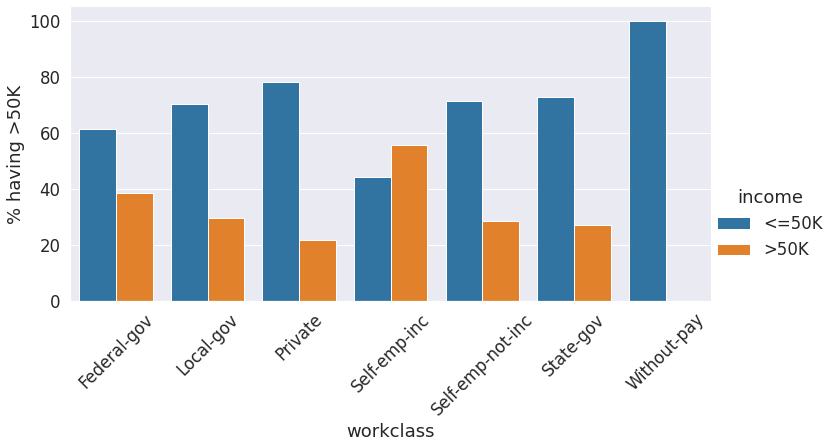

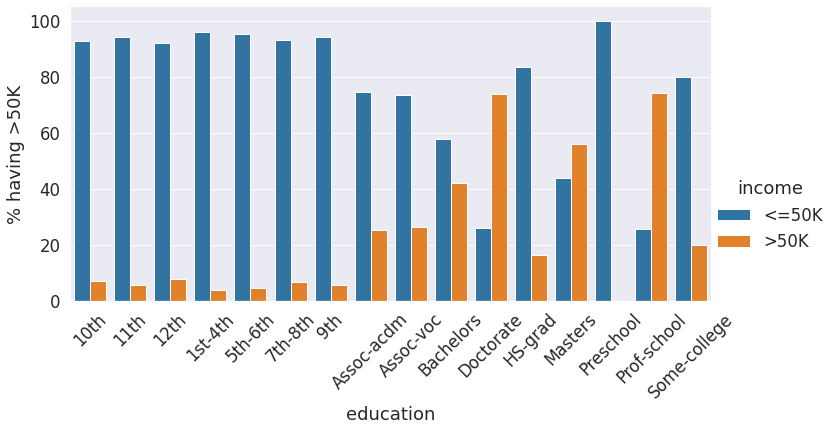

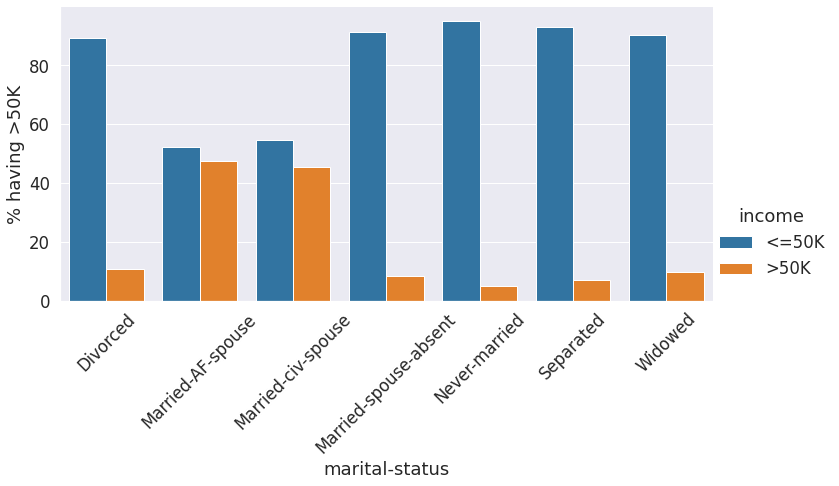

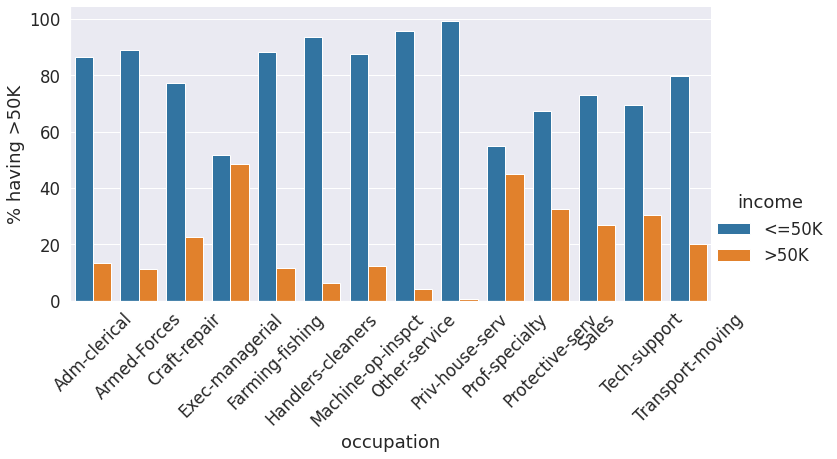

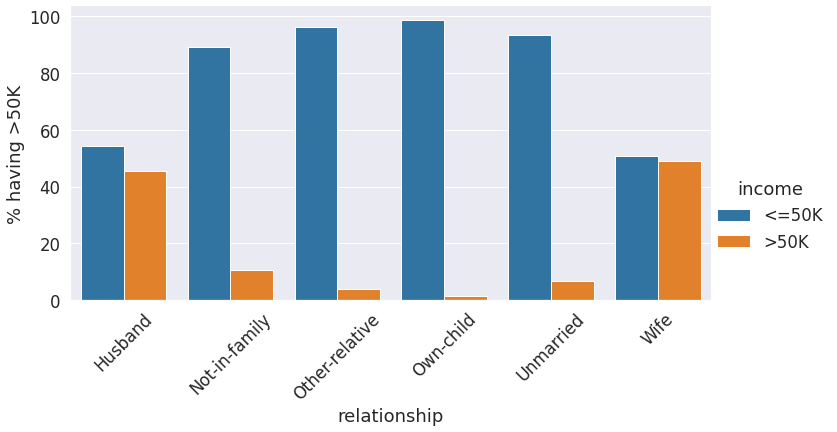

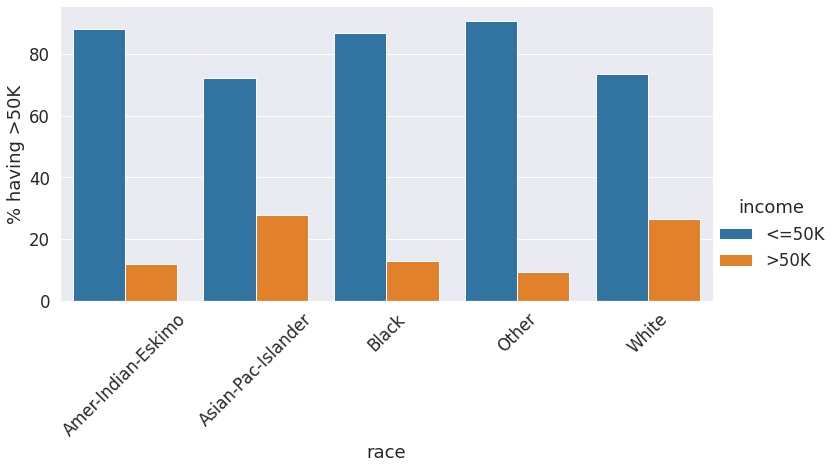

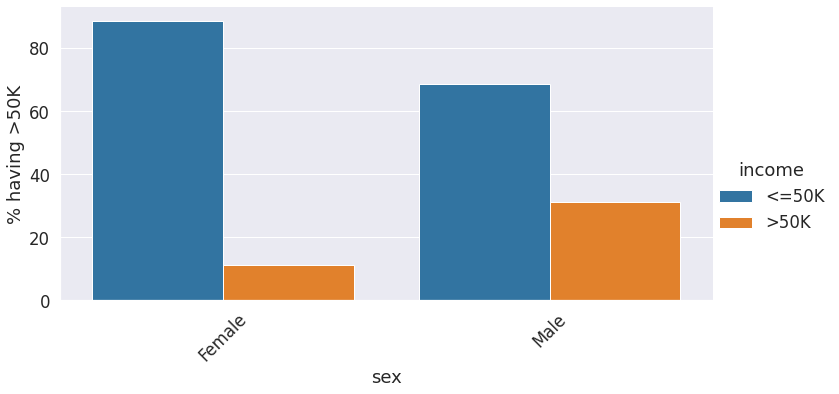

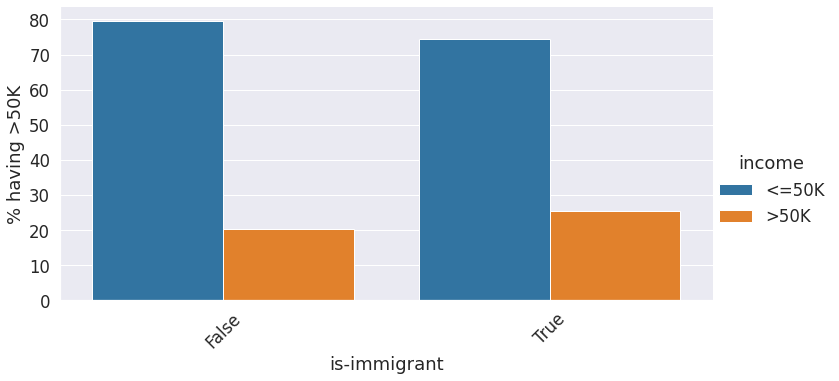

In [ ]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):

    for feature in cat_features:
        tmp_df = (
            train_df_no_missing.groupby(feature)['income'].value_counts(
                normalize=True
            )
        )
        tmp_df = tmp_df.mul(100).rename('% having >50K').reset_index()
        g = sns.catplot(
            data=tmp_df,
            x=feature,
            y='% having >50K',
            kind='bar',
            hue='income',
            height=5,
            aspect=2,
        )
        g.ax.set_xticklabels(
            g.ax.get_xticklabels(), 
            rotation=45
        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



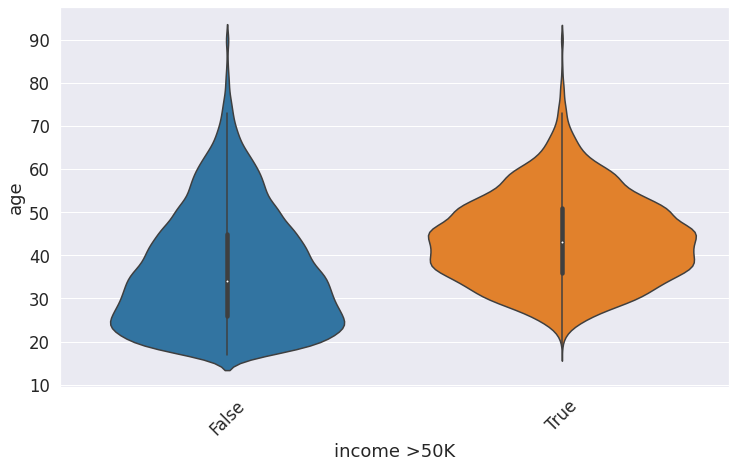

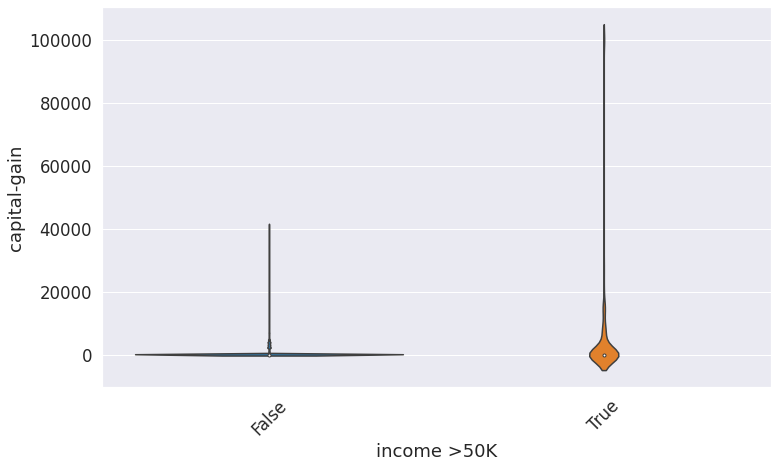

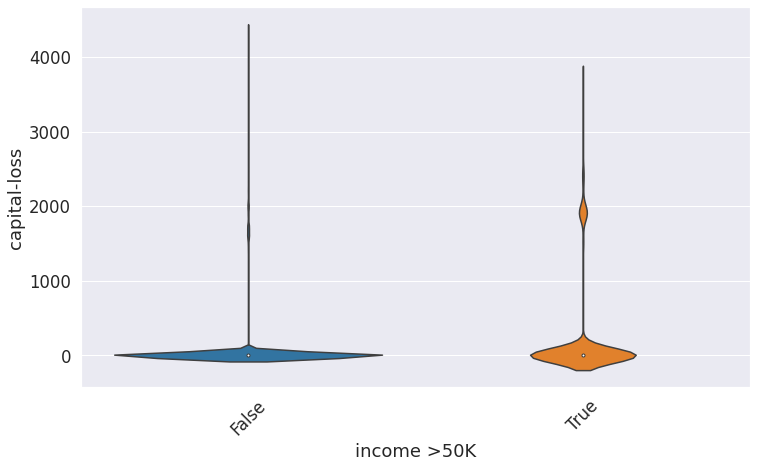

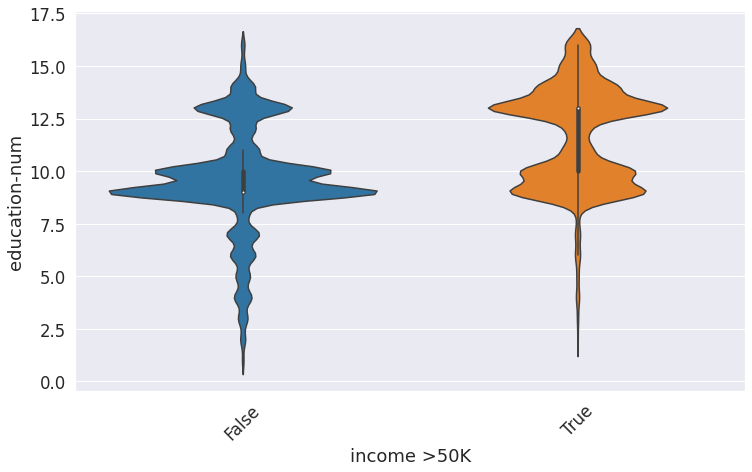

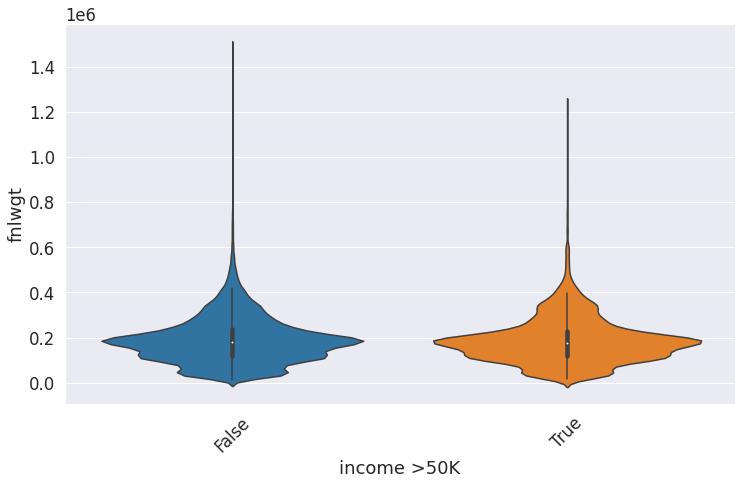

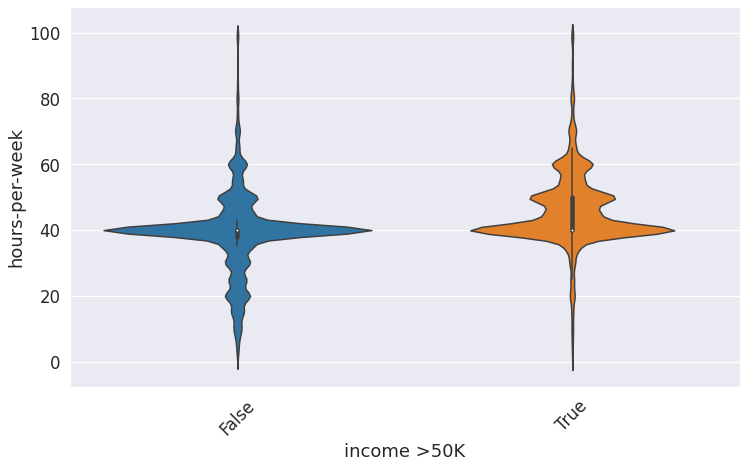

In [ ]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):
    train_df_no_missing['income >50K'] = (
        train_df_no_missing['income'] == '>50K'
    )
    for feature in np.setdiff1d(
        train_df.columns, 
        cat_features + ['income', 'income >50K']
    ): 
        fig, ax = plt.subplots(figsize=(12, 7))
        ax = sns.violinplot(
            data=train_df_no_missing,
            y=feature,
            x='income >50K',
            ax=ax
        )
        ax.set_xticklabels(
            ax.get_xticklabels(), 
            rotation=45
        )
        fig.show()

## Обучение алгоритма


Теперь переведём обучающую, валидационную и тестовую выборки в нативный для алгоритмов из `catboost` формат `catboost.Pool`. Он позволяет разметить столбцы `pd.DataFrame` на **числовые**, **категориальные**, **эмбеддинговые** и **текстовые**, чтобы алгоритм смог применить к ним правильные преобразования.

О работе с текстовыми и эмбеддинговыми признаками мы поговорим на следующих занятиях. Пока что сосредоточимся на числовых и категориальных признаках.

In [ ]:
train_pool = catboost.Pool(
    train_X,
    label=train_y,
    cat_features=cat_features
)
val_pool = catboost.Pool(
    val_X,
    label=val_y,
    cat_features=cat_features
)
test_pool = catboost.Pool(
    test_X,
    label=test_y,
    cat_features=cat_features
)


## Обучение алгоритма

**Ключевые гиперпараметры:**
- `iterations` -- количество итераций;
- `loss_function` -- функция ошибок (LogLoss или CrossEntropyLoss);
- `learning_rate` -- длина градиентного шага. Вычисляется автоматически на основе количества итераций и размера обучающей выборки;
- `depth` -- глубина деревьев;
- `rsm` -- использовать ли метод случайных подпространств при построении деревьев (по умолчанию отключено);
- `one_hot_max_size` -- максимальная мощность категориального признака, при которой к нему всё ещё применяется one-hot encoding. 

С полным списком гиперпараметров можно ознакомиться в официальной документации: https://catboost.ai/docs/concepts/python-reference_parameters-list.html 

---

Сильная сторона `CatBoost` в том, что он показывает достойное качество при значениях гиперпараметров по умолчанию. Тем не менее, это не означает, что его не следует пытаться конфигурировать! Мы рассмотрим несколько основных настроек, которые позволяют существенно улучшить качество предсказания и, в целом, ощущения от работы с этим инструментом:

- **Использование GPU для ускорения вычислений.** Одна из самых сильных сторон `CatBoost` -- возможность обучения на GPU. На малых данных прирост качества незаметен, но на достаточно больших, production-level данных возможен 40-кратный прирост при сравнении достаточно мощной GPU (V100) против достаточно мощного CPU. Для того, чтобы использовать GPU, достаточно выставить `task_type='GPU'`. Если в вашем распоряжении несколько GPU, `CatBoost` умеет использовать их для распределённого обучения. От вас требуется только перечислить их названия / номера через запятую в параметре `devices`.

- **Вычисление метрик качества на каждой итерации.** LogLoss, который алгоритм пытается минимизировать, это неинтерпретируемая величина. Но `CatBoost` умеет в реальном времени подсчитывать привычные метрики качества в духе ROC-AUC, F1, Precision, Recall, Accuracy etc. Достаточно просто перечислить их в параметре `eval_metric` в конструкторе.

- **Автоматическая детекция переобучения**. Если у вас есть валидационная выборка, вы можете использовать поведение функции ошибок на ней для того, чтобы понять, что алгоритм начал переобучаться, и остановить его обучение. Степень уверенности в этом задаётся параметром `od_pval` (от 0 до 1, причём чем меньше, тем меньше вероятность ложного срабатывания, но и тем выше шанс потратить много итераций впустую). Количество шагов, которые нужно подождать после того, как алгоритм начал переобучаться, контролируется парамеров `od_wait`. 

- **Автоматический выбор лучшей модели по метрикам качества на валидационной выборке.** Достаточно прописать `use_best_model=True` в конструкторе объекта.

- **Автоматический учёт дисбаланса классов.** Один из самых простых способов борьбы с дисбалансом классов в данных -- взвешение слагаемых в выражении для кросс-энтропии. Если 75% объектов имеет класс 0, а 25% имеет класс 1, то ошибку на объектах положительного класса нужно учитывать с тройным весом. Веса классов можно задать вручную через параметр `class_weights`, но `CatBoost` умеет делать это автоматически -- достаточно просто передать в конструктор параметр `auto_class_weights='Balanced'`. 

- **Early stopping.** Предыдущий метод ранней остановки обучения алгоритма опирается на т.н. *детекцию разладки* -- статистический метод определения момента начала аномального поведения системы. Есть более простой, более интерпретируемый способ -- т.н. *early stopping*, который останавливает обучение, если метрика качества на валидационной выборке не улучшается на протяжении наперёд заданного количества шагов, которое контролируется параметром `early_stopping_rounds`. 

- **Checkpoints.** Если ваш алгоритм обучается достаточно долго (скажем, несколько часов), вы захотите сохранять промежуточные результаты на диск, чтобы потом, в случае непредвиденной ошибки в духе отказа оборудования, начать не с нуля, а с последнего чекпоинта. Для сохранения чекпоинтов достаточно задать параметр `train_dir` в конструкторе и прописать `save_snapshot=True`, `snapshot_file=...` в параметрах метода `fit`.

- **Baseline.** Если у вас уже есть достаточно хороший алгоритм другой природы (скажем, метрический), то вы можете обучить бустинг корректировать его ошибки. Достаточно просто передать предсказания имеющейся модели через параметр `baseline`. Типичный пример такой ситуации -- бустинг на огромном количестве сложных признаков (категориальные, эмбеддинговые, текстовые etc) поверх линейной модели, в которой признаки были подобраны экспертами в предметной области. Условно говоря, ясно, что время доставки можно неплохо приблизить через расстояние и то, сколько, в среднем, занимает доставка в этот район, но есть множество факторов, которые в линейную модель не добавишь, и именно тут выручает бустинг.

---

Кроме того, при обработке категориальных признаков `CatBoost` смотрит также на их сочетания, т.к. иногда возможен т.н. *эпистаз* -- значения двух признаков по отдельности не играют особой роли, а вот вместе они являются сильным предиктором значения целевой переменной. Максимальное количество сочетаемых признаков контролируется параметром `max_ctr_complexity`. Чем выше значение этого параметра, тем, обычно, выше качество предсказания, но при этом сильно растёт количество потребляемой памяти, и вы не всегда можете себе это позволить, особенно на больших данных.

---

По умолчанию `CatBoost` печатает отчёт по каждой итерации обучения. Когда итераций много, следить за каждой из них нет смысла. Можно выставить параметр  `metric_period=N`, чтобы отчёт выводился раз в `N` итераций. 

Если же в методе `fit` указать `plot=True` то будет выводиться красивый график с метриками, но в `Colab` это не работает. :(

In [ ]:
?catboost.CatBoostClassifier

In [ ]:
!rm -rf 'catboost_clf_on_adult/snapshot.bkp'

In [ ]:
catboost_train_dir = 'catboost_clf_on_adult'
clf = catboost.CatBoostClassifier(
    eval_metric='AUC',
    od_pval=0.05,
    od_wait=20,
    # early_stopping_rounds=20,
    random_seed=28,
    train_dir=catboost_train_dir,
    task_type='CPU',
    # task_type='GPU',
    # devices='0',
    auto_class_weights='Balanced',
    max_ctr_complexity=4,
    use_best_model=True
)
clf.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.071944
0:	test: 0.8723564	best: 0.8723564 (0)	total: 197ms	remaining: 3m 17s
1:	test: 0.8842103	best: 0.8842103 (1)	total: 353ms	remaining: 2m 56s
2:	test: 0.8826354	best: 0.8842103 (1)	total: 451ms	remaining: 2m 29s
3:	test: 0.8868454	best: 0.8868454 (3)	total: 529ms	remaining: 2m 11s
4:	test: 0.8902734	best: 0.8902734 (4)	total: 595ms	remaining: 1m 58s
5:	test: 0.8946035	best: 0.8946035 (5)	total: 646ms	remaining: 1m 47s
6:	test: 0.8952203	best: 0.8952203 (6)	total: 723ms	remaining: 1m 42s
7:	test: 0.8973213	best: 0.8973213 (7)	total: 779ms	remaining: 1m 36s
8:	test: 0.8983341	best: 0.8983341 (8)	total: 832ms	remaining: 1m 31s
9:	test: 0.8994169	best: 0.8994169 (9)	total: 892ms	remaining: 1m 28s
10:	test: 0.9002504	best: 0.9002504 (10)	total: 965ms	remaining: 1m 26s
11:	test: 0.9006179	best: 0.9006179 (11)	total: 1.02s	remaining: 1m 23s
12:	test: 0.9012930	best: 0.9012930 (12)	total: 1.07s	remaining: 1m 21s
13:	test: 0.9017132	best: 0.9017132 (13)	total: 1.12s	

## Post-hoc анализ

Обучив модель, можно оценить её качество на любом другом датасете, где вам известны ответы, при помощи метода `eval_metrics`.

In [ ]:
test_metrics = clf.eval_metrics(
    test_pool,
    metrics=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'],
    ntree_start=clf.best_iteration_ - 1,
    ntree_end=clf.best_iteration_,
    eval_period=1,
    thread_count=-1
)

In [ ]:
test_metrics

{'AUC': [0.926308772243469],
 'Accuracy': [0.8424571276832906],
 'F1': [0.8434317169512147],
 'Precision': [0.8321873654717794],
 'Recall': [0.8549840933191941]}

Кроме того, модель хранит в себе поле с значениями важности признаков. Это **не** MDI и **не** permutation-based importances, которые мы рассматривали на занятии. Ознакомиться с алгоритмом их вычисления можно в официальной документации: https://catboost.ai/docs/concepts/fstr.html#fstr__regular-feature-importance

In [ ]:
sorted(
    zip(train_X.columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

[('capital-gain', 22.058777633047143),
 ('relationship', 16.236038369007233),
 ('age', 13.71055008265815),
 ('capital-loss', 7.687464054098279),
 ('occupation', 7.607498128931248),
 ('hours-per-week', 7.438981257631485),
 ('marital-status', 5.925255769979037),
 ('education-num', 5.2267457373334665),
 ('education', 4.187254408658098),
 ('fnlwgt', 3.377951742059446),
 ('workclass', 2.6734908572975407),
 ('sex', 1.730307949016058),
 ('race', 1.5677859676620325),
 ('is-immigrant', 0.5718980426207781)]

--- 

Тем не менее, хотелось бы понимать, какой вклад каждый конкретный признак даёт в предсказание модели на каждом конкретном объекте. Для решения этой задачи есть механизм SHAP values, который интегрирован в `CatBoost`:

In [ ]:
shap_info = clf.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

Processing trees...
128/395 trees processed	passed time: 209ms	remaining time: 436ms
395/395 trees processed	passed time: 586ms	remaining time: 0us
Processing documents...
128/27646 documents processed	passed time: 15ms	remaining time: 3.22s
10112/27646 documents processed	passed time: 1.21s	remaining time: 2.1s
20096/27646 documents processed	passed time: 2.38s	remaining time: 895ms
27646/27646 documents processed	passed time: 3.26s	remaining time: 0us


In [ ]:
shap_values.shape

(27646, 14)

`summary_plot` позволяет проанализировать влияние признаков на предсказание в целом.

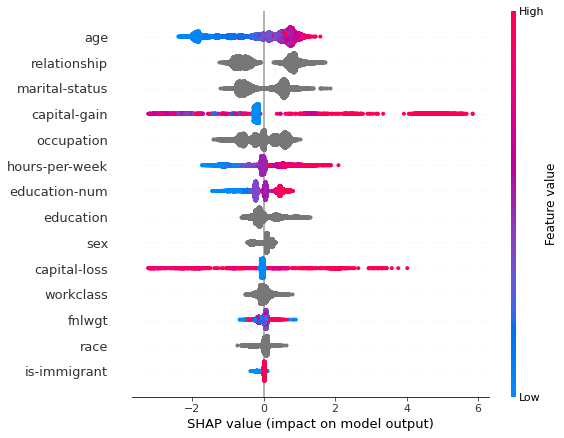

In [ ]:
shap.summary_plot(shap_values, train_X)

---

В CatBoost также есть симпатичный метод `clf.calc_feature_statistics`, который должен выводить совместное распределение признака, целевой переменной, предсказания модели. 

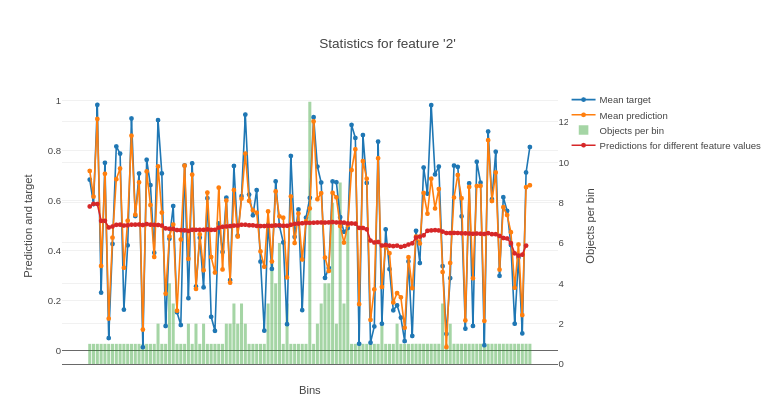

Но заставить его работать в Colab -- та ещё задача. ¯\\_(ツ)_/¯  Если получится, напишите мне.

Кроме того эта функция требует, чтобы модель умела делать one-hot encoding для всех признаков. Т.е. чтобы параметр `one_hot_max_size` был достаточно большим. Это чревато проклятием размерности из-за не очень важных признаков большой мощности. Но если у вас таких нет, то можете смело использовать этот метод.

In [ ]:
?clf.calc_feature_statistics

In [ ]:
clf.calc_feature_statistics(train_pool)

CatBoostError: ignored

Смотрим только на первый по порядку признак (здесь должен быть график, но CatBoost не дружит с Colab).

In [ ]:
clf.calc_feature_statistics(train_pool, feature=0)